# Сегментация экземпляров на предобученной Mask R-CNN

In [ ]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
# Метод maskrcnn_resnet50_fpn из библиотеки torchvision.models.detection — это готовая реализация архитектуры Mask R-CNN
# с предобученными весами, где в качестве основы (backbone) используется ResNet-50 с Feature Pyramid Network (FPN).
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import defaultdict

## Задача 1

Модифицируйте код сегментации экземпляров на предобученной Mask R-CNN, чтобы он обнаруживал только объекты определенных классов (например, только людей и автомобили).

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# Список классов COCO (91 категория)
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
] # N/A - Это placeholder-ы для неиспользуемых индексов (в оригинальном датасете COCO есть "пропуски" в нумерации категорий).

In [ ]:
# Загрузка предобученной модели Mask R-CNN
model = maskrcnn_resnet50_fpn(pretrained=True) # С предобученными весами на COCO
model.eval()  # Переводим модель в режим оценки

# 2. Загрузка и подготовка изображения
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device) # сразу добавляем размерность батча
    return image, image_tensor

image_path = '/content/cat_human.png'  # Путь к изображению
original_image, image_tensor = load_image(image_path)

# 3. Выполнение предсказания
with torch.no_grad():
    predictions = model(image_tensor)

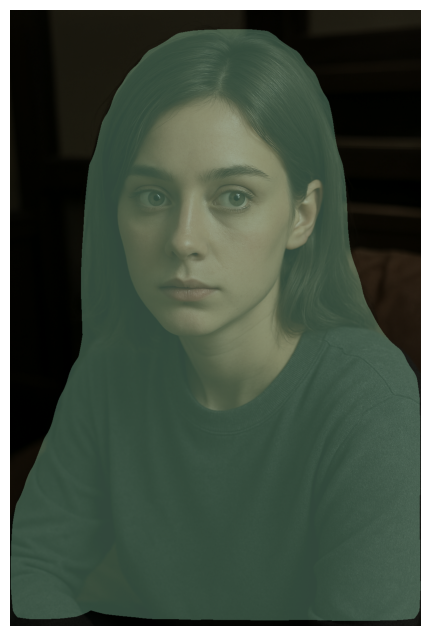

In [ ]:
# Указание нужных классов (COCO class IDs): 1 — person, 3 — car
target_classes = [1, 3]

def visualize_prediction(image, prediction, target_classes):
    prediction = {k: v.cpu() for k, v in prediction.items()}  # На CPU

    image_np = np.array(image)

    # Получаем нужные маски, метки и оценки
    masks = prediction['masks'] > 0.5
    labels = prediction['labels']
    scores = prediction['scores']

    filtered_masks = []
    for i in range(len(masks)):
        if labels[i].item() in target_classes and scores[i].item() > 0.5:  # можно задать порог выше, например 0.7
            filtered_masks.append(masks[i].squeeze(0).numpy())

    if not filtered_masks:
        print("Нет объектов целевых классов на изображении.")
        return

    # Создаем цветную маску
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)
    for mask in filtered_masks:
        color = np.random.randint(0, 255, size=3)
        colored_mask[mask] = color

    # Наложение
    alpha = 0.5
    result = cv2.addWeighted(image_np, 1 - alpha, colored_mask, alpha, 0)

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.show()

# Визуализация только целевых объектов
visualize_prediction(original_image, predictions[0], target_classes)

In [ ]:
target_classes = [3]
visualize_prediction(original_image, predictions[0], target_classes)

Нет объектов целевых классов на изображении.


## Задача 2

Добавьте отрисовку bounding box поверх масок (используйте cv2.rectangle). Сделайте разные цвета для разных классов.

In [ ]:
def visualize_prediction(image, prediction, target_classes):

    prediction = {k: v.cpu() for k, v in prediction.items()}
    image_np = np.array(image)

    masks = prediction['masks'] > 0.5
    labels = prediction['labels']
    scores = prediction['scores']
    boxes = prediction['boxes']

    COCO_CLASSES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
        'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
        'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    # Назначим цвет для каждого класса
    class_colors = {}
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)

    for i in range(len(masks)):
        label_id = labels[i].item()
        score = scores[i].item()

        if label_id in target_classes and score > 0.5:
            mask = masks[i].squeeze(0).numpy()
            box = boxes[i].numpy().astype(int)
            class_name = COCO_CLASSES[label_id]

            # Назначаем постоянный цвет для класса, если еще не был назначен
            if label_id not in class_colors:
                class_colors[label_id] = np.random.randint(0, 255, size=3)

            color = class_colors[label_id]

            # Закрашиваем маску
            colored_mask[mask] = color

            # Рисуем bounding box
            cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color.tolist(), 2)

            # Добавляем подпись
            text = f"{class_name}: {score:.2f}"
            cv2.putText(image_np, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color.tolist(), 2, lineType=cv2.LINE_AA)

    # Наложение маски
    alpha = 0.5
    result = cv2.addWeighted(image_np, 1 - alpha, colored_mask, alpha, 0)

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.show()

In [ ]:
image_path2 = '/content/pepe.jpg'  # Путь к изображению
original_image2, image_tensor2 = load_image(image_path2)
with torch.no_grad():
    predictions2 = model(image_tensor2)

In [ ]:
image_path = '/content/cat_human.png'  # Путь к изображению
original_image, image_tensor = load_image(image_path)
with torch.no_grad():
    predictions = model(image_tensor)

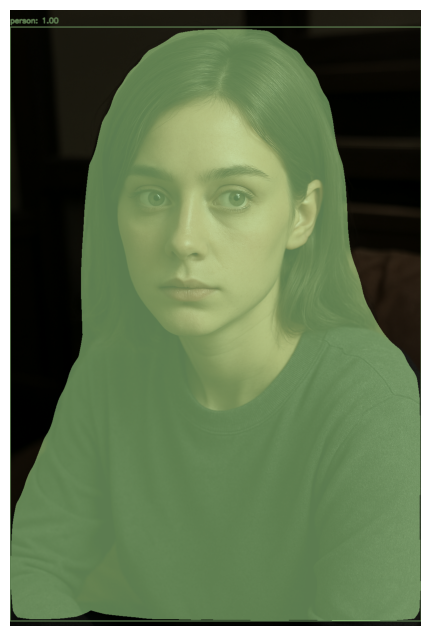

In [ ]:
target_classes = [1, 3]
visualize_prediction(original_image, predictions[0], target_classes)

## Задача 3

Реализуйте подсчет количества обнаруженных объектов каждого класса (вывод в консоль таблицы: класс → количество).

In [ ]:
def visualize_prediction(image, prediction, target_classes):
    prediction = {k: v.cpu() for k, v in prediction.items()}
    image_np = np.array(image)

    masks = prediction['masks'] > 0.5
    labels = prediction['labels']
    scores = prediction['scores']
    boxes = prediction['boxes']

    COCO_CLASSES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
        'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
        'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    class_colors = {}
    class_counts = defaultdict(int)
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)

    for i in range(len(masks)):
        label_id = labels[i].item()
        score = scores[i].item()

        if label_id in target_classes and score > 0.5:
            mask = masks[i].squeeze(0).numpy()
            box = boxes[i].numpy().astype(int)
            class_name = COCO_CLASSES[label_id]

            # Цвет для класса
            if label_id not in class_colors:
                class_colors[label_id] = np.random.randint(0, 255, size=3)
            color = class_colors[label_id]

            # Увеличиваем счётчик
            class_counts[class_name] += 1

            # Маска + bbox + подпись
            colored_mask[mask] = color
            cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color.tolist(), 2)
            text = f"{class_name}: {score:.2f}"
            cv2.putText(image_np, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color.tolist(), 2, lineType=cv2.LINE_AA)

    # Визуализация
    alpha = 0.5
    result = cv2.addWeighted(image_np, 1 - alpha, colored_mask, alpha, 0)

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.show()

    # Вывод таблицы в консоль
    if class_counts:
        print("\nОбнаруженные объекты:")
        print("{:<15} {:>10}".format("Класс", "Количество"))
        print("-" * 27)
        for class_name, count in class_counts.items():
            print("{:<15} {:>10}".format(class_name, count))
    else:
        print("\nНет объектов целевых классов на изображении.")

In [ ]:
image_path3 = '/content/arni.jpg'  # Путь к изображению
original_image3, image_tensor3 = load_image(image_path3)
with torch.no_grad():
    predictions3 = model(image_tensor3)

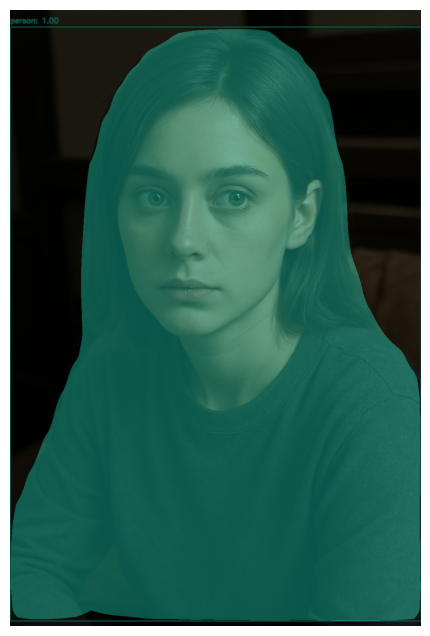


Обнаруженные объекты:
Класс           Количество
---------------------------
person                   1


In [ ]:
visualize_prediction(original_image, predictions[0], target_classes=[1, 3])

## Задача 4

Модифицируйте код для обработки видеофайла (по кадрам) с сохранением результата.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

# Классы COCO
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
    'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
    'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Цвета для классов
class_colors = {}
TARGET_CLASSES = [1, 3, 22]  # person, car

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def process_frame(frame):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    masks = prediction['masks'] > 0.5
    labels = prediction['labels']
    scores = prediction['scores']
    boxes = prediction['boxes']

    result_frame = frame.copy()
    overlay = np.zeros_like(frame, dtype=np.uint8)

    for i in range(len(masks)):
        label_id = labels[i].item()
        score = scores[i].item()

        if label_id in TARGET_CLASSES and score > 0.5:
            class_name = COCO_CLASSES[label_id]
            mask = masks[i].squeeze(0).cpu().numpy()
            box = boxes[i].cpu().numpy().astype(int)

            # Цвет для класса
            if label_id not in class_colors:
                class_colors[label_id] = np.random.randint(0, 255, size=3)
            color = class_colors[label_id]

            # Маска
            overlay[mask] = color

            # Bounding box
            cv2.rectangle(result_frame, (box[0], box[1]), (box[2], box[3]), color.tolist(), 2)

            # Подпись
            cv2.putText(result_frame, f"{class_name} {score:.2f}",
                        (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        color.tolist(), 2, lineType=cv2.LINE_AA)

    # Смешивание
    alpha = 0.5
    combined = cv2.addWeighted(result_frame, 1 - alpha, overlay, alpha, 0)
    return combined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к видео
input_video_path = "/content/drive/MyDrive/computer vision/лаба4/ele.mp4"
output_video_path = "/content/drive/MyDrive/computer vision/лаба4/ele_out2.mp4"

# Захват видео
cap = cv2.VideoCapture(input_video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Сохраняем выходное видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # или 'XVID'
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Обработка {frame_count} кадров...")

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    result = process_frame(frame)
    out.write(result)

    frame_idx += 1
    if frame_idx % 10 == 0:
        print(f"[{frame_idx}/{frame_count}]")
    if frame_idx > 30:
        break

cap.release()
out.release()
print("✅ Обработка завершена и видео сохранено.")

Обработка 540 кадров...
[10/540]
[20/540]
[30/540]
✅ Обработка завершена и видео сохранено.


In [ ]:
from moviepy.editor import VideoFileClip

  if event.key is 'enter':



In [ ]:
clip = VideoFileClip('/content/drive/MyDrive/computer vision/лаба4/ele_out2.mp4')
clip.ipython_display(width=640)

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


## Задача 5

Замените случайные цвета на фиксированные для каждого класса (люди – красные, машины – синие и т.д.). Используйте словарь class_colors.

In [ ]:
def visualize_prediction(image, prediction, target_classes):
    prediction = {k: v.cpu() for k, v in prediction.items()}
    image_np = np.array(image)

    masks = prediction['masks'] > 0.5
    labels = prediction['labels']
    scores = prediction['scores']
    boxes = prediction['boxes']

    COCO_CLASSES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
        'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
        'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A',
        'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    # Фиксированные цвета по классам (BGR)
    class_colors = {
        1: (0, 0, 255),     # person - красный
        3: (255, 0, 0),     # car - синий
        22: (0, 255, 0),    # elephant - зелёный
        24: (255, 255, 0),  # zebra - голубой
        25: (128, 0, 128),  # giraffe - фиолетовый
    }

    class_counts = defaultdict(int)
    colored_mask = np.zeros_like(image_np, dtype=np.uint8)

    for i in range(len(masks)):
        label_id = labels[i].item()
        score = scores[i].item()

        if label_id in target_classes and score > 0.5:
            mask = masks[i].squeeze(0).numpy()
            box = boxes[i].numpy().astype(int)
            class_name = COCO_CLASSES[label_id]

            # Получение цвета (по умолчанию — белый)
            color = class_colors.get(label_id, (255, 255, 255))

            class_counts[class_name] += 1
            colored_mask[mask] = color

            cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), color, 2)
            text = f"{class_name}: {score:.2f}"
            cv2.putText(image_np, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, color, 2, lineType=cv2.LINE_AA)

    # Смешивание маски и исходного изображения
    alpha = 0.5
    result = cv2.addWeighted(image_np, 1 - alpha, colored_mask, alpha, 0)

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.axis('off')
    plt.show()

    # Вывод в консоль
    if class_counts:
        print("\nОбнаруженные объекты:")
        print("{:<15} {:>10}".format("Класс", "Количество"))
        print("-" * 27)
        for class_name, count in class_counts.items():
            print("{:<15} {:>10}".format(class_name, count))
    else:
        print("\nНет объектов целевых классов на изображении.")

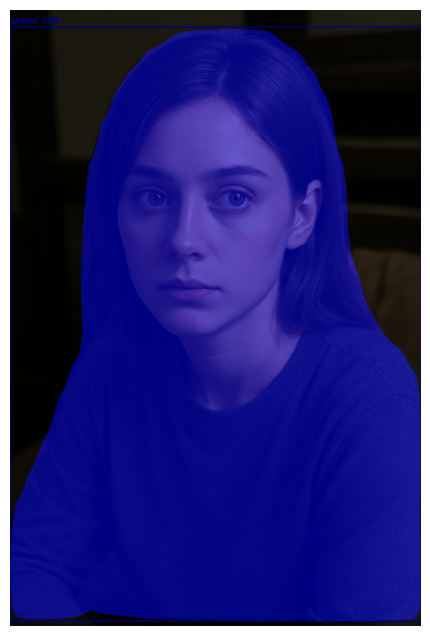


Обнаруженные объекты:
Класс           Количество
---------------------------
person                   1


In [ ]:
visualize_prediction(original_image, predictions[0], target_classes=[1, 3])

## Задача 6

Добавьте сохранение бинарных масок для каждого объекта (PNG) и аннотаций в COCO-формате (JSON)

In [ ]:
import os
import json
from PIL import Image as PILImage
from pycocotools import mask as coco_mask

In [ ]:
def save_binary_masks_and_annotations(prediction, image_id, output_dir, coco_classes):
    os.makedirs(f"{output_dir}/masks", exist_ok=True)
    os.makedirs(f"{output_dir}/annotations", exist_ok=True)

    prediction = {k: v.cpu() for k, v in prediction.items()}
    masks = prediction['masks'] > 0.5
    labels = prediction['labels']
    scores = prediction['scores']
    boxes = prediction['boxes']

    annotations = []
    ann_id = 0

    for i in range(len(masks)):
        label_id = labels[i].item()
        score = scores[i].item()
        if score < 0.5:
            continue

        mask = masks[i].squeeze(0).numpy().astype(np.uint8)  # shape: (H, W)
        class_name = coco_classes[label_id]

        # Сохранение PNG
        mask_filename = f"{image_id}_obj_{i}_{class_name}.png"
        PILImage.fromarray(mask * 255).save(os.path.join(output_dir, "masks", mask_filename))

        # Аннотация COCO
        rle = coco_mask.encode(np.asfortranarray(mask))
        area = coco_mask.area(rle).item()
        bbox = coco_mask.toBbox(rle).tolist()  # [x, y, width, height]

        annotation = {
            "id": ann_id,
            "image_id": image_id,
            "category_id": label_id,
            "segmentation": {
            "size": rle["size"],
            "counts": rle["counts"].decode("utf-8")  # вот тут исправление
            },
            "area": area,
            "bbox": bbox,
            "iscrowd": 0
        }
        annotations.append(annotation)
        ann_id += 1

    return annotations

In [ ]:
def save_coco_json(image_filename, image_id, image_size, annotations, output_dir, coco_classes):
    categories = [{"id": i, "name": name} for i, name in enumerate(coco_classes) if name != "N/A"]
    coco_dict = {
        "images": [{
            "id": image_id,
            "file_name": image_filename,
            "height": image_size[1],
            "width": image_size[0]
        }],
        "annotations": annotations,
        "categories": categories
    }

    with open(os.path.join(output_dir, "annotations", f"{image_id}_annotations.json"), "w") as f:
        json.dump(coco_dict, f, indent=4)

In [ ]:
image_id = 1  # можно генерировать автоматически
output_dir = "/content/output"  # путь, где будут храниться маски и JSON

annotations = save_binary_masks_and_annotations(predictions[0], image_id, output_dir, COCO_CLASSES)
save_coco_json(os.path.basename(image_path), image_id, original_image.size, annotations, output_dir, COCO_CLASSES)

In [ ]:
annotations

[{'id': 0,
  'image_id': 1,
  'category_id': 1,
  'segmentation': {'size': [1536, 1024],
   'counts': b'aZ4d2V\\1c1SOl0VOj0YOe0_O=C9H8H8I7I6J6J7K4L4M3M3M3N1N2N2N2N2N3M2N2M3N2M3N2M4M2M3M3M3L4M3M3M4L3N2M3N2M3N2N2N3M2N2N2O1N2N2O1N2N2N2N2N2N2M3N2M3N2M3M3N2M3N2M3M3N2M3N2M3N2M3M3N2M3N2M3N2N2N2N2O1N2N2O1N2O1N2N2N2N2N2N2M3N2M3M2N3M3L4L4L4L4L4L4M3L4M3L4M3M3M3M3M3N2M3N2N2N1O2N2N2N2O1N2N2N2N2N2M2O2M3N2M3M3M3L4M2N3L4M3M3N2M3N2M2O2N2N2N2O1N2N2O0O2O1N2O1N2O0O2O1N1O2M3K4L5K5K4L5mI_]Oa^Ogb0h`0j^OX^O[a0Sa0X@i]Oo?ha0_AS]Of>`b0d7A?_O`0^Oc0^Oa0C>E:F;F:F9H9G8H9H7J7I6J6O2M2O2N1O2N3M2M3N3L3N2M3M4L3M3L5L3L4L4K6J5L4K5L5K4L4L4L5K4L4M3L5M2N2N2N3M2N2N2O1N3N1N2O1N2N2N2N2N3M2N2M3N2M3M3M3M4L3N2M3M3N2N2N2N2N3M2N2N2O1N2N2O1O1N3N1O1N2O1O1N2O1N2O2M2N2N2N2O1N2N2O1N2O1N3N1N2O1O1O1N2O1O1O1O2N1O1O1O1O1O1O1O100O1O2N1O1O1O1O1O1N2O2N1O1N2O1N2O1N2N2O2N1N2O1O1O1O1O1O1O1O2N1O1O1O1O1O100O100O100O100O2O0O100O100O100O100O100O100O1O100O100O100O1O100O100O100O1O100O100O1O100O1O100O1O100O1O1O100O1O1O100O100O1O100O100O1O100O100O100O10000

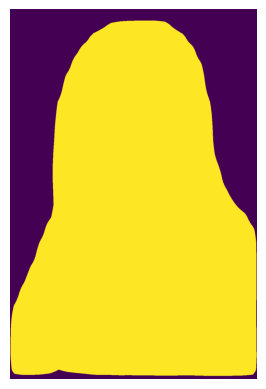

In [ ]:
image = Image.open('/content/output/masks/1_obj_0_person.png')
plt.imshow(image)
plt.axis('off')
plt.show()